# Where is the ground on this seismic section?

The notebook shows how to inspect an SEGY file of a land-based seismic line for ground-elevation information, and to synthetically add the ground level as a pickable event at the top of the section. The line used in this exercise, 36-77-PR, was selected somewhat randomly from the [USGS National Petroleum Reserve - Alaska Data Archive](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx). You can find and download field records, processed SEGY files, handwritten field notes, images, and observer logs.


![Old Seismic Plot line 36-77](Alaska/36_77_IM.JPG)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!/usr/bin/python	
import numpy as np
from scipy import interpolate
from scipy.signal import convolve
import matplotlib.pyplot as plt

from obspy.segy.segy import readSEGY
from obspy.core.utcdatetime import UTCDateTime

from bruges.filters import ricker

% matplotlib inline

data come from here:
    
    http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx

I've placed the relevant files for this line in the nearby folder:

In [3]:
datadir = 'Alaska/'
segyfile = '36_77_PR.sgy'
filename = datadir + segyfile
print ("SEGY File: " + filename)

SEGY File: Alaska/36_77_PR.sgy


## Load the SEGY file and look at the textual file header

In [4]:
def text_header_lines(header):
    """
    Takes SEGY textual header and turns it into a list of strings
    Where each string is one line (80 Characters long)
    This just prints nicely
    """
    header_list = []
    for i in range(80):
        header_list.append(header[80*(i-1):80*i])
    return header_list

In [5]:
section = readSEGY(filename,unpack_headers=True)
text_header_lines(section.textual_file_header)[0:41]  # this prints nicer

[b'',
 b'C 1                                                                             ',
 b'C 2     \x00 Q \x00  \x00\x00 V \x00                                                           ',
 b'C 3         660321SY                                                            ',
 b'C 4                                                                             ',
 b'C 5                                                                             ',
 b'C 6                                                                             ',
 b'C 7                                                                             ',
 b'C 8                                                                             ',
 b'C 9                                                                             ',
 b'C10                                                                             ',
 b'C11                                                                             ',
 b'C12                           

Oh dear, there's no useful information in the textual file header. Let's probe into some attributes of the trace headers and see if there is any information we can extract.

## Let's look at some values we might need from the trace headers

In [6]:
ntraces = len(section.traces)
print (ntraces)

1560


In [7]:
# Choose a number between 1 and len(section.traces)
n = 99  
tr = section.traces[n] # the 100 th trace in the file

In [19]:
print ('TRACE:', n)
print('CMP:', tr.header.ensemble_number)
print('XL:', tr.header.for_3d_poststack_data_this_field_is_for_cross_line_number)
print('IL:', tr.header.for_3d_poststack_data_this_field_is_for_in_line_number)
print('ESP:', tr.header.energy_source_point_number)
print('X:', tr.header.group_coordinate_x)
print('Y:', tr.header.group_coordinate_y)
print('X_ens:', tr.header.x_coordinate_of_ensemble_position_of_this_trace)
print('Y_ens:', tr.header.y_coordinate_of_ensemble_position_of_this_trace)
print('datum (rec):', tr.header.datum_elevation_at_receiver_group)
print('datum (source):', tr.header.datum_elevation_at_source)
print('static (ms):', tr.header.group_static_correction_in_ms)
print('r_elev:', tr.header.receiver_group_elevation)
print('s_elev:', tr.header.surface_elevation_at_source)
print('sbs_elev:', tr.header.source_depth_below_surface)
print('sub_weath_vel:', tr.header.subweathering_velocity)
print('weath_vel:', tr.header.weathering_velocity)
print('scalar_xy:', tr.header.scalar_to_be_applied_to_all_coordinates)
print('scalar_to_z:', tr.header.scalar_to_be_applied_to_all_elevations_and_depths)
print('scalar_to_sp:', tr.header.scalar_to_be_applied_to_the_shotpoint_number)
print('scalar_time:', tr.header.scalar_to_be_applied_to_times)

TRACE: 99
CMP: 248
XL: 0
IL: 0
ESP: 0
X: 0
Y: 0
X_ens: 1396965609
Y_ens: 0
datum (rec): 0
datum (source): 0
static (ms): 0
r_elev: 0
s_elev: 0
sbs_elev: 0
sub_weath_vel: 0
weath_vel: 0
scalar_xy: 1
scalar_to_z: 1
scalar_to_sp: 0
scalar_time: 0


Oh dear, there doesn't seem to be any useful information in the trace headers either. Who made this file?! 

# Getting the elevations
Unfortunately, the coordinates (x,y,z) for the top of each trace is missing in this particular SEGY file, so we have to get that information from somewhere else. 

I'll just go after the elevations, and I'll save the x, y coordinates for another exercise. If we were really proactive, we could write the missing information back into correct trace header byte locations for safekeeping. But I'll save that for another exercise.



The elevation information for the ground level isn't in the SEGY file, but ground elevation and datum plots are contained in the original seismic wiggle plot:

![Old Seismic Plot line 36-77](Alaska/36_77_IM.JPG)

https://certmapper.cr.usgs.gov/nersl/NPRA/seismic/1977/36_77/IMAGES/36_77_IM.JPG

I've digitzed these using [WebPlotDigitizer](http://arohatgi.info/WebPlotDigitizer/), and stored them as CSV files

In [9]:
SP_elev_file = 'Alaska/36-77_CMP_elevs.csv'
datum_elev_file = 'Alaska/36-77_Datum_elevs.csv'

In [10]:
def load_elevs(file):
    """
    A function to load our simple two-column csv file.
    Return x (horz) and z (vertical) arrays
    """
    
    with open(file) as f:
        geoms = f.readlines()

        # heads = geoms[0]  # no header

        x, z = [], []

        for line in geoms:
            line = line.strip()
            columns = line.split(',')
            x.append(columns[0])
            z.append(columns[1])

    x = np.array(x, 'float')
    z = np.array(z, 'float')
    return x, z

In [11]:
cmp, z = load_elevs(SP_elev_file)  # CMP number and  ground elevation  
x_d, z_d = load_elevs(datum_elev_file) # coordinates of (variable) datum

From the JPEG of the seismic line we can read off the first and last CMP values.

In [12]:
first_CMP, last_CMP = 149, 1708  # Looking this up on the JPG we have available

In [13]:
cmp_new = np.arange(first_CMP, last_CMP+1, 1.0)
fg = interpolate.interp1d(cmp, z/3.2808)  # feet to metres
fd = interpolate.interp1d(x_d, z_d/3.2808)  # feet to metres
z_new = fg(cmp_new)  # use interpolation function returned by `interp1d`
SRD = fd(cmp_new)  # seismic reference datum (SRD)

### Plotting the elevation profile relative to the seismic reference datum (SRD)

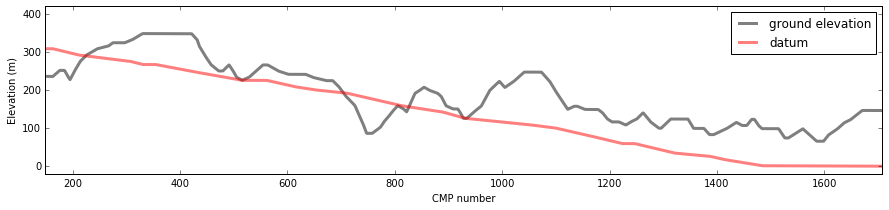

In [14]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)

# plot ground level
ax.plot(cmp_new, z_new, 'k', lw=3, alpha=0.5, label='ground elevation')

# plot seismic reference datum (SRD)
ax.plot(cmp_new, SRD,'r', lw=3, alpha=0.5, label='datum')

# prettying the plot
ax.invert_xaxis()
ax.set_xlabel('CMP number')
ax.set_ylabel('Elevation (m)')

ax.set_ylim(-20,420)
ax.set_xlim(first_CMP, last_CMP)
ax.legend()

# fig.savefig('ground_level_depth_structure.png')

Oh god, we've got a variable datum...That's gross. But we can manage it.

# Calculate the ground level travel-time surface

Referring to the JPG once again, we see the replacement velocity is 10,000 ft/s. Converting this into SI units we can calculate the travel time between the seismic reference datum and ground level:

In [15]:
try_flat_datum = False
if try_flat_datum:
    datum = 400
    SRD = datum*np.ones_like(z_new)

In [16]:
rep_vel = 10000.0 / 3.2808  # convert to SI units
constant = 0
ground_time = 2000*((SRD-z_new+constant) / rep_vel )

### Plotting the ground-level in the time domain

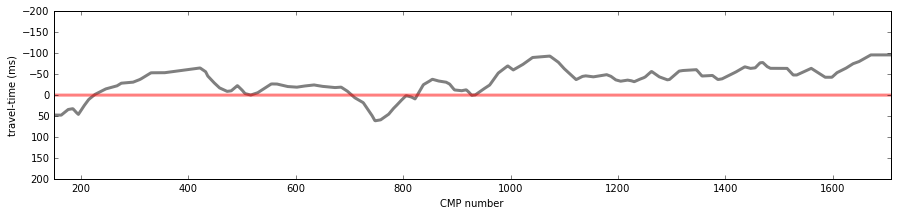

In [17]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)

# plot ground level
ax.plot(cmp_new, ground_time, 'k', lw=3, alpha=0.5)

# plot SRD
ax.plot(cmp_new,0*np.ones(len(cmp_new)),'r', lw=3, alpha=0.5)

# prettying the plot
ax.invert_xaxis()
ax.set_xlabel('CMP number')
ax.set_ylabel('travel-time (ms)')
ax.set_ylim(200,-200)
ax.set_xlim(first_CMP, last_CMP)
ax.legend()

# fig.savefig('ground_level_time_structure.png')

# Plot the ground-level on the seismic data

In [22]:
# Get the data as a 2D matrix from the traces (using a list comprehension)
data = np.vstack([d.data for d in section.traces])

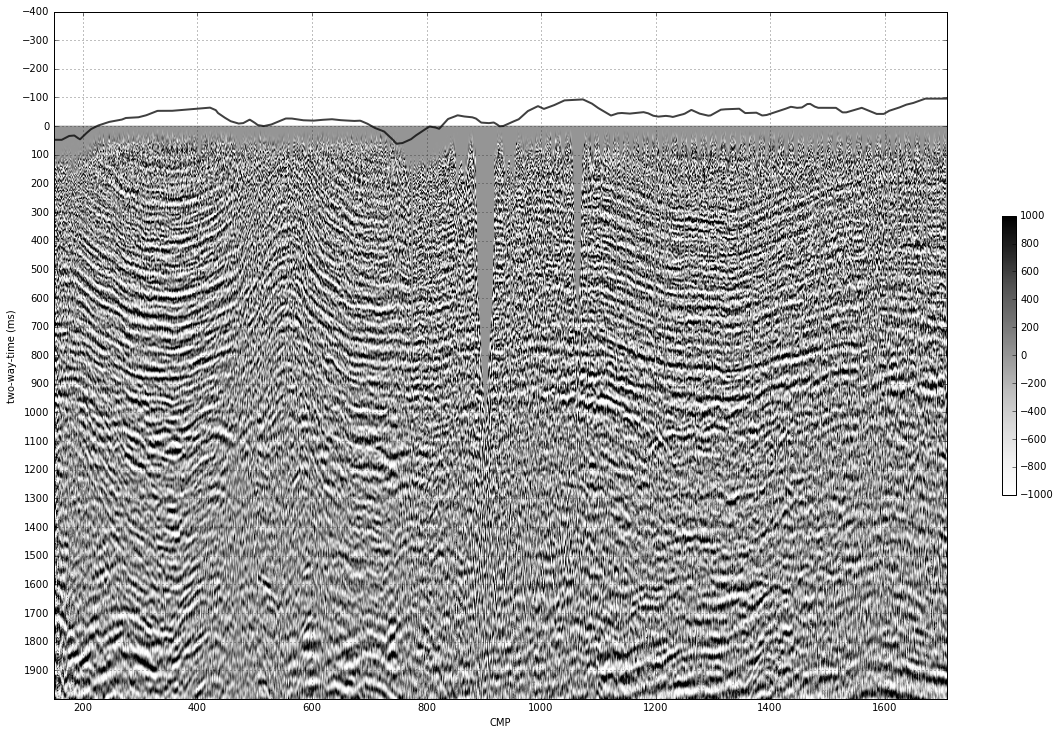

In [23]:
maxsamp = 1500  # only want to plot this much of the trace from the top
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
 
# plot ground level
ax.plot(cmp_new, ground_time, 'k', lw=2, alpha=0.75)

# plot the data
im = ax.imshow(data.T[:maxsamp,::-1], cmap="Greys", aspect=0.5, clim=(-1e3,1e3),
               extent = [np.amax(cmp), np.amin(cmp), maxsamp*dt*1000,0])

ax.set_xlim(np.amin(cmp_new),  np.amax(cmp_new))
ax.set_ylim(2000, np.amin(-200))
ax.set_yticks(np.arange(-400,2000,100))

ax.set_ylabel('two-way-time (ms)')
ax.set_xlabel('CMP')
ax.grid()

# Add a colorbar
fig.colorbar(im, ax=ax, shrink=0.25)

## Burn the ground-level into the data


In [24]:
def make_synthetic_ground(w, ground_time, pad):
    n_traces, n_samples = data.shape
    synth = np.zeros((n_samples+len(w)-1+pad, n_traces))
    w = w / max(w)   # normalize
    for k in range(n_traces):
        spike = np.zeros(n_samples+pad)
        spike[int(ground_time[k]/(1000*dt)+pad)] = 1
        synth[:,k] = convolve(spike, w)
    synth = synth[ np.ceil(len(w))/2 : -np.ceil(len(w))/2 + 1, : ]
    return np.transpose(synth)

In [25]:
duration = 0.256
dt = tr.header.sample_interval_in_ms_for_this_trace / 1e6
f = 25.0  # dominant frequency in Hz.
w = ricker(duration, dt, f)

ground = make_synthetic_ground(w, ground_time, pad = 50)

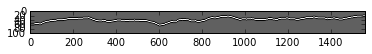

In [26]:
plt.imshow(ground.T[0:100,:], cmap='Greys_r')  # Here's our ground in the dimensions of our datum shifted profile

In [27]:
burn_val = np.percentile(data, 99)
n_traces, n_samples = data.shape
pad = 50
data_pad = np.zeros((ntraces, pad))
datumed_data = np.hstack([data_pad, data])
burned_seismic = burn_val*ground + datumed_data

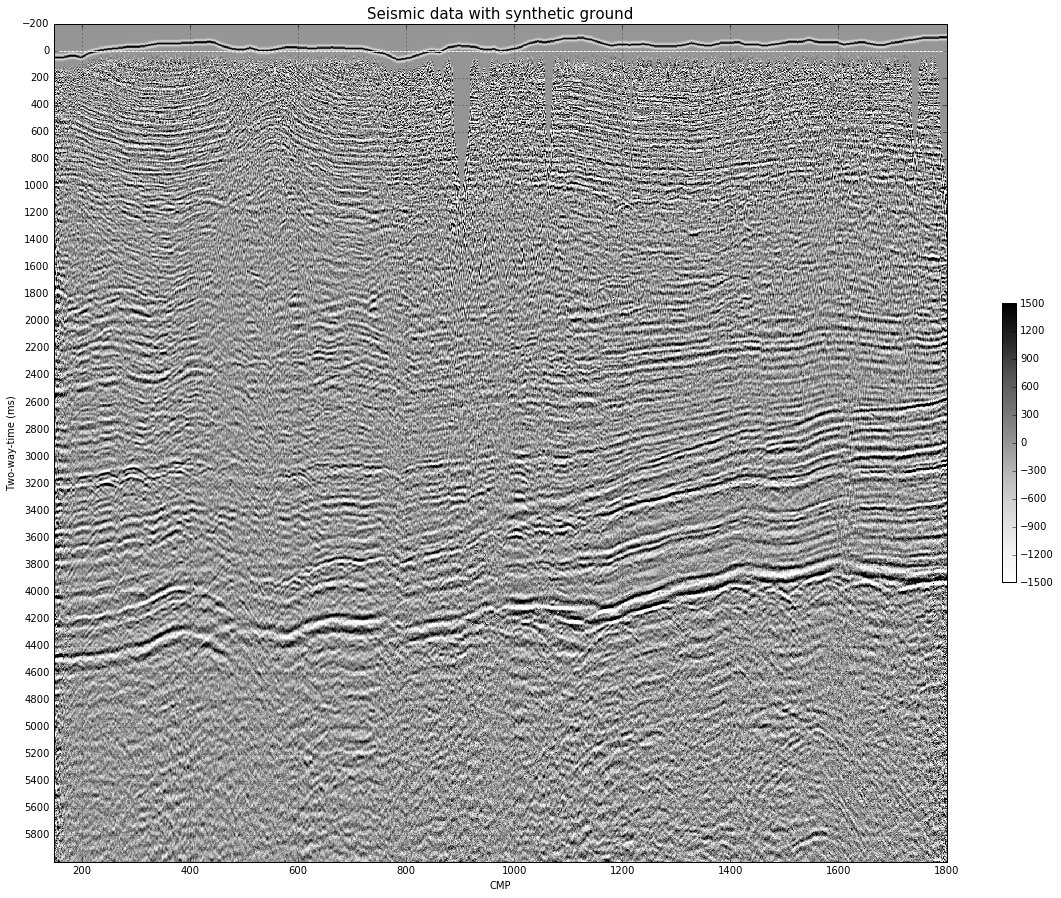

In [28]:
maxt = 1500
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

# place line at ground level
plt.axhline(y=0, xmin=0, xmax=1.0, linewidth=1, color = 'w')

# show data
im = ax.imshow(np.transpose(burned_seismic)[:int(maxt),:], cmap="Greys", aspect=0.25, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp), maxt*dt*1000, -200 ], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
ax.set_yticks(np.arange(-200,6000,200))

ax.set_ylabel('Two-way-time (ms)')
ax.set_xlabel('CMP')
ax.set_title('Seismic data with synthetic ground',  size=15)
ax.grid()

# Add a colorbar
fig.colorbar(im, ax=ax, shrink=0.25)
fig.savefig('full_section_earth_surface_included.png')

## Zoomed in figure (for PickThis)

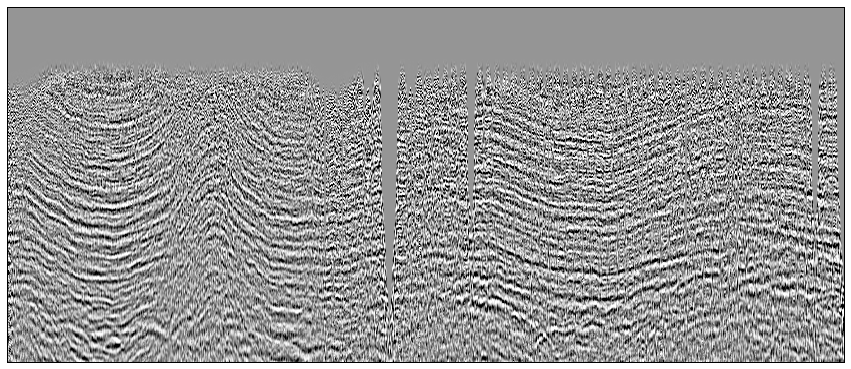

In [29]:
maxt = 300
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(datumed_data)[:int(maxt)+pad,:], cmap="Greys", aspect=0.5, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-pad*dt*1000], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(1200,-200)

# Add a colorbar
#fig.colorbar(im, ax=ax, shrink=0.25)

fig.savefig('where_da_ground_at.png')

## Zoomed in figure

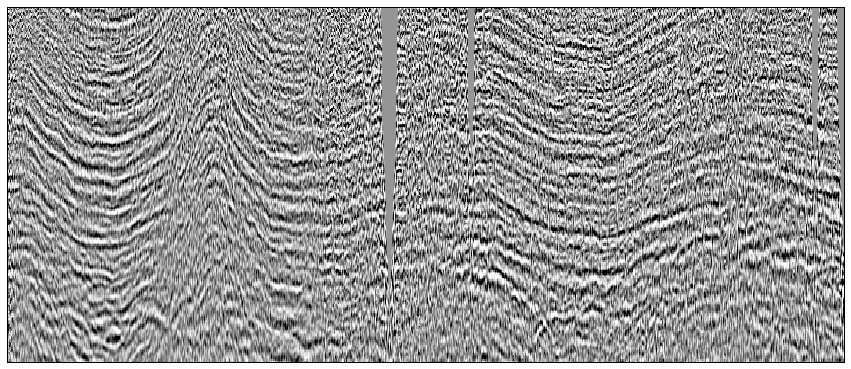

In [30]:
maxt = 300
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(burned_seismic)[:int(maxt)+pad,:], cmap="Greys", aspect=0.5, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-800], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
#ax.set_ylabel('Two-way-time (ms)')
#ax.set_xlabel('CMP')
#ax.set_title('AFTER',  size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(1200,-200)

fig.savefig('here_da_ground_at.png')